In [2]:
import numpy as np
import scipy.linalg
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time 

In [3]:
# Best practice source:
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(72730)))

In [4]:
# Generate simulated data 
# Must have rows > cols 
rows=100
cols = 10
sigma_true = .5
x = np.random.normal(size=(rows, cols))
beta_true = np.multiply(np.random.normal(size=cols), np.random.uniform(-6,6,cols))
y = np.matmul(x, beta_true) + sigma_true*np.random.normal(size=rows)

In [5]:
# Use scipy qr decomposition to solve for betas 
decomp = scipy.linalg.qr(x)
print("Dimensions of Q: ", decomp[0].shape)
print("Dimensions of R: ", decomp[1].shape)

Dimensions of Q:  (100, 100)
Dimensions of R:  (100, 10)


In [6]:
# Verify that Q is orthogonal 
print("Q'Q: ", np.matmul(decomp[0], decomp[0].T).round(10))
print("Det of Q: ", scipy.linalg.det(decomp[0]))

Q'Q:  [[ 1.  0. -0. ...  0. -0. -0.]
 [ 0.  1.  0. ...  0.  0. -0.]
 [-0.  0.  1. ... -0.  0.  0.]
 ...
 [ 0.  0. -0. ...  1.  0.  0.]
 [-0.  0.  0. ...  0.  1.  0.]
 [-0. -0.  0. ...  0.  0.  1.]]
Det of Q:  0.9999999999999973


In [7]:
# Verify that we can recover X 
np.allclose(np.dot(decomp[0], decomp[1]), x)

True

In [8]:
# Solve for beta using R%*%Beta = Q^t%*%y 
qty = np.matmul(decomp[0].T, y.reshape(-1,1))
# Need to use the linearly indepdentent part of R, corresponding QtY
beta_hat = scipy.linalg.solve_triangular(decomp[1][:cols, :cols], qty[:cols])

In [9]:
# Verify that we're close to the true beta 
print("Difference in Beta Hat vs Beta True:")
np.subtract(beta_hat, np.reshape(beta_true, (-1,1)))

Difference in Beta Hat vs Beta True:


array([[-0.00162599],
       [ 0.02088693],
       [-0.01837579],
       [-0.00955505],
       [ 0.05290002],
       [-0.06398848],
       [ 0.02099508],
       [ 0.03783499],
       [-0.02104521],
       [-0.02193136]])

In [10]:
# Verify that we're close to the fitted beta from sklearn
lfit = LinearRegression() #L2 reg is 1/C
# need numpy 2dim array for X
# X = x.reshape((n,1)).copy()
lfit.fit(x,y)
print("Differences in sklearn vs backsolve: ")
np.subtract(beta_hat, np.reshape(lfit.coef_, (-1,1)))
# Looking good! 

Differences in sklearn vs backsolve: 


array([[-0.00047994],
       [ 0.00048207],
       [ 0.00103336],
       [ 0.00115028],
       [-0.0082071 ],
       [ 0.00152503],
       [ 0.00179532],
       [-0.00707368],
       [-0.00821804],
       [ 0.00276569]])

In [11]:
# Check runtime at varying rows, cols
row_space = np.linspace(10, 10**3, num=10**2, dtype=int)
col_space = np.linspace(10, 10**3, num=10**2, dtype=int)
outputs = np.zeros((row_space.shape[0], col_space.shape[0]))
outputs.shape

(100, 100)

In [12]:
# time the qr decomp for different rows, cols
for i in range(row_space.shape[0]):
    if i % 10 == 0:
        print(f"Outer loop: {i}")
    for j in range(col_space.shape[0]):
        start = time.time()
        tmp = scipy.linalg.qr(np.random.normal(size=(row_space[i], col_space[i])))
        outputs[i,j] = time.time() - start

Outer loop: 0
Outer loop: 10
Outer loop: 20
Outer loop: 30
Outer loop: 40
Outer loop: 50
Outer loop: 60
Outer loop: 70
Outer loop: 80
Outer loop: 90


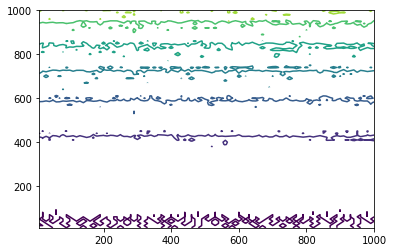

In [13]:
plt.contour(row_space, col_space, outputs)